<a href="https://colab.research.google.com/github/ManuelAlejandrG/Python/blob/master/Data_Analyst_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space AG Data Analyst Challenge

En la celda posterior mientras la instalación necesaria de sentinelhub

In [1]:
# instalación sentinelhub
!pip install sentinelhub

Luego de instalar, se crea una cuenta la cual arroja un id para configurar la conexión.

In [0]:
from sentinelhub import SHConfig

# Configuración de la instancia 
INSTANCE_ID = '955e74c8-86b8-41c0-bce7-e4dc3a26a754'  
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None



Importamos los paquetes necesarios para la extracción de las imágenes

In [0]:
# Importaciones necesarias

import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Hacemos conexión con google drive de donde obtendremos el documento excel para las fechas disponibles y el documento json con las ubicaciones de los lugares a extraer imagenes

In [4]:
from google.colab import drive

# conexión con drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Leemos el documento excel de google drive

In [0]:
# lectura del documento excel
data_available = pd.read_excel("/content/drive/My Drive/SentinelHubImage-available_dates.xlsx")  

Leemos el json y lo decodificamos para que python lo reconozca como un diccionario

In [0]:
# lectura del documento json

f = open("/content/drive/My Drive/farm_map.json", 'r')
content = f.read()

json_decod = json.loads(content)

Empleamos la lista llamada `aux` la cual tiene 2 iteraciones. 
La primera sobre los 33 regiones disponibles (o lote) que hay en el json y la siguiente sobre los 5 puntos posible en cada region ( o lote)

In [0]:
# auxiliar para extraer las coordenadas del json

aux = []
for j in range(33):
    for i in range(5):
        aux.append(json_decod["features"][j]["geometry"]["coordinates"][0][i])

Luego de obtener la lista `aux`, le asignamos los valores a una variable llamada `bordes` para que contenga las coordenadas de todos los lotes 

In [0]:
# bordes para la obtener las imagenes

bordes = []
for j in range(164):
    bordes.append([aux[j],aux[j+1]])

Creamos la función `grafica_nvdi` que sirve para tomar el valor promedio de NVDI.
Esta función pide por argumento un valor `i` y una `fecha`.
El valor `i`  irá iterando sobre la variable `bordes`creada anteriormente y la variable `fecha`le asignaremos las fechas disponibles extrayendolas de la variable `data_available`.

En `imagen_bbox` obtenemos el rectángulo de la imagen y hacemos la petición de la imagen la cual se la asignamos a `wms_bands_request`, luego en `wms_bands_img` extraemos todos los datos de la imagen.

La data extraida tiene 13 canales de los cuales solo nos iteresan el 8 correspondiente al NIR y el 4 correspondiente al Red.

Luego hacemos la fórmula para calcular el NVDI la cual es $$ NVID =  \frac{NIR-Red}{ NIR + Red} $$ despues tomamos la media de ese valor y lo retornamos, ahora en el caso que haya dado un error que retorne un valor nan


In [0]:
# funcion para obtener el nvdi promedio

def grafica_nvdi2(i, fecha):
  """
  funcion para obtener el nvdi promedio
  i: entero, para iterar la lista bordes
  fecha: date, fecha disponible para las imágenes
  """
  # box para obtener la imagen 
  imagen_bbox = BBox(bbox=[bordes[i][0][0],
                                bordes[i][0][1],
                                bordes[i][1][0],
                                bordes[i][1][1]], 
                          crs=CRS.WGS84) 
  try:
    # request de la imagen
    wms_bands_request = WmsRequest(
        layer='BANDS-S2-L1C',
        bbox=imagen_bbox,
        time=fecha,
        width=512,
        height=856,
        image_format=MimeType.TIFF_d32f,
        config=config)
    # data de la imagen
    wms_bands_img = wms_bands_request.get_data()

    # la data tiene un 13 canales, el canal 8 es el correspondiente al NIR y
    # canal 4 es el correspondiente a Red
    # calculamos al termino NVDI
    nvdi = wms_bands_img[-1][:, :, 8]- wms_bands_img[-1][:, :, 4] / wms_bands_img[-1][:, :, 4] + wms_bands_img[-1][:, :, 8]
        
    # pedimos la media
    mean = nvdi.mean()
    
  except:
    # si tenemos un error que arroge un valor nan
    mean = np.nan

  
  return mean

En este punto creamos un dataframes llamado `valores`, le asignamos una columna llamada `index` y luego en el ciclo creamos columnas con el nombre de la fecha y las filas serán las entradas correspondiente de iterar la funcion `grafica_nvdi2` por todos los indices correspondientes. 

De igual manera el 32 proviene de las regiones (o lotes) y el 89 de las fechas disponibles en el dataframe.

In [10]:
valores = pd.DataFrame()
valores["index"] = range(32)
for i in range(89):
  print(i)
  valores[data_available._date[i]] = valores["index"].apply(grafica_nvdi2, fecha=data_available._date[i])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


Cambiamos filas por columnas y definimos un nuevo dataset para hacer estudio

In [11]:
h = pd.DataFrame(valores.values.T)
h.index = valores.columns
h.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
index,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.0,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000,31.000000
2020-04-20,-0.301580,-0.311074,-0.306710,-0.369529,-0.301580,-0.304153,-0.401819,-0.320132,-0.311074,-0.315242,-0.297560,-0.317424,-0.301580,-0.383529,-0.297560,-0.309464,-0.383334,-0.304153,-0.317424,NaN,-0.297560,-0.370985,-0.311993,-0.310105,-0.309464,-0.309464,-0.310105,-0.305912,-0.400908,-0.325125,-0.315086,-0.333911
2020-04-15,-0.281805,-0.296356,-0.289081,-0.353830,-0.281805,-0.287686,-0.395538,-0.303002,-0.296356,-0.293417,-0.278736,-0.293436,-0.281805,-0.367038,-0.278736,-0.289217,-0.374959,-0.287686,-0.293436,NaN,-0.278736,-0.351099,-0.291187,-0.289212,-0.289217,-0.289217,-0.289212,-0.288095,-0.389091,-0.305769,-0.291950,-0.309935
2020-03-11,-0.262843,-0.278999,-0.290659,-0.353606,-0.262843,-0.262605,-0.347015,-0.296505,-0.278999,-0.267750,-0.252428,-0.264308,-0.262843,-0.356121,-0.252428,-0.260733,-0.356335,-0.262605,-0.264308,NaN,-0.252428,-0.343231,-0.256971,-0.259925,-0.260733,-0.260733,-0.259925,-0.250872,-0.357054,-0.273667,-0.256614,-0.272693
2020-02-15,-0.263919,-0.279291,-0.288605,-0.354231,-0.263919,-0.266976,-0.355228,-0.296257,-0.279291,-0.278301,-0.259395,-0.272671,-0.263919,-0.366133,-0.259395,-0.262834,-0.382508,-0.266976,-0.272671,NaN,-0.259395,-0.349722,-0.260522,-0.265968,-0.262834,-0.262834,-0.265968,-0.253217,-0.358272,-0.275620,-0.261620,-0.267013


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
index,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.0,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000,31.000000
2020-04-20,-0.301580,-0.311074,-0.306710,-0.369529,-0.301580,-0.304153,-0.401819,-0.320132,-0.311074,-0.315242,-0.297560,-0.317424,-0.301580,-0.383529,-0.297560,-0.309464,-0.383334,-0.304153,-0.317424,NaN,-0.297560,-0.370985,-0.311993,-0.310105,-0.309464,-0.309464,-0.310105,-0.305912,-0.400908,-0.325125,-0.315086,-0.333911
2020-04-15,-0.281805,-0.296356,-0.289081,-0.353830,-0.281805,-0.287686,-0.395538,-0.303002,-0.296356,-0.293417,-0.278736,-0.293436,-0.281805,-0.367038,-0.278736,-0.289217,-0.374959,-0.287686,-0.293436,NaN,-0.278736,-0.351099,-0.291187,-0.289212,-0.289217,-0.289217,-0.289212,-0.288095,-0.389091,-0.305769,-0.291950,-0.309935
2020-03-11,-0.262843,-0.278999,-0.290659,-0.353606,-0.262843,-0.262605,-0.347015,-0.296505,-0.278999,-0.267750,-0.252428,-0.264308,-0.262843,-0.356121,-0.252428,-0.260733,-0.356335,-0.262605,-0.264308,NaN,-0.252428,-0.343231,-0.256971,-0.259925,-0.260733,-0.260733,-0.259925,-0.250872,-0.357054,-0.273667,-0.256614,-0.272693
2020-02-15,-0.263919,-0.279291,-0.288605,-0.354231,-0.263919,-0.266976,-0.355228,-0.296257,-0.279291,-0.278301,-0.259395,-0.272671,-0.263919,-0.366133,-0.259395,-0.262834,-0.382508,-0.266976,-0.272671,NaN,-0.259395,-0.349722,-0.260522,-0.265968,-0.262834,-0.262834,-0.265968,-0.253217,-0.358272,-0.275620,-0.261620,-0.267013


Tomamos una fila en aleatorio del dataset h para hacer un estudio general de su serie temporal

In [19]:
import random
random.seed(10)
i = random.randint(0,31)
print(i)
L = pd.DataFrame(h[i][1:])

2


Calculamos el promedio de el promedio movil de los 5 valores anteriores y se lo a la columna `5-rolling-mean`. Ademas graficamos L para ver la serie temporal general y la media movil 

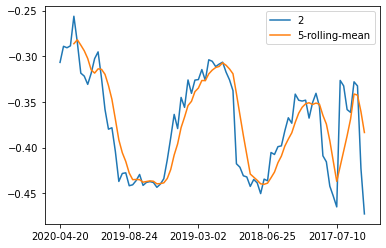

In [20]:
L["5-rolling-mean"] = L[i].rolling(5).mean()
L.plot()

Ahora calculamos la varianza diaria y se lo asignamos a la columna `varianza-diaria` y graficamos esta serie


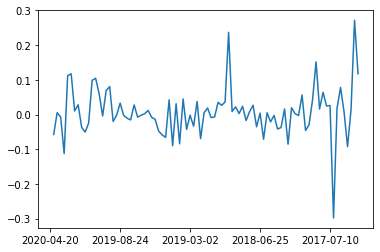

In [21]:
L["varianza-diaria"] = L[i].pct_change()
L["varianza-diaria"].plot()

Ahora ejecutemos el modelo ARIMA ya que estamos en presencia de una serie de tiempo y así podamos predecir su comportamiento

predicciones=-0.438327, observación=-0.450379
predicciones=-0.454980, observación=-0.434543
predicciones=-0.433321, observación=-0.436362
predicciones=-0.438244, observación=-0.405382
predicciones=-0.404451, observación=-0.407549
predicciones=-0.399864, observación=-0.398994
predicciones=-0.401438, observación=-0.398102
predicciones=-0.393122, observación=-0.381570
predicciones=-0.385309, observación=-0.367349
predicciones=-0.362015, observación=-0.373294
predicciones=-0.372531, observación=-0.341451
predicciones=-0.337274, observación=-0.348156
predicciones=-0.342956, observación=-0.349058
predicciones=-0.351382, observación=-0.348091
predicciones=-0.344046, observación=-0.367723
predicciones=-0.373060, observación=-0.350906
predicciones=-0.353923, observación=-0.340569
predicciones=-0.338230, observación=-0.355050
predicciones=-0.354813, observación=-0.408988
predicciones=-0.411880, observación=-0.415578
predicciones=-0.424501, observación=-0.442244
predicciones=-0.451151, observació

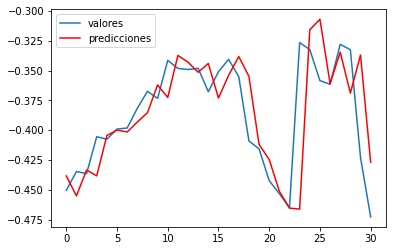

In [89]:
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


X = L[i].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicciones=%f, observación=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test, label="valores")
plt.plot(predictions, color='red', label="predicciones")
plt.legend()
plt.show()

Como podemos ver, el modelo se comporta bastante bien, con un error cuadrático medio de 0.001.